# Analysing COVID-19 Data
## Priya Chotalia

For the second portfolio we'll look at the most relevant dataset to our lives at the moment: the global spread of COVID-19.   There is an open dataset avaialable that is updated often showing the number of cases in different regions of the world.  This is the source of the graphs and visualisations that you'll see on the news. 

Here are some sample stories for reference:

* [From the ABC](https://www.abc.net.au/news/2020-03-26/coronavirus-covid19-global-spread-data-explained/12089028)
* [From the Guardian](https://www.theguardian.com/australia-news/datablog/ng-interactive/2020/apr/06/coronavirus-cases-in-australia-map-curve-confirmed-numbers-stats-how-many-covid-19-nsw-by-postcode-maps-victoria-live-data-qld-sa-wa-tas-nt-act-latest-statistics)
* [Coronavirus in Australia](https://www.covid19data.com.au/)
* [ArcGIS Dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) Johns Hopkins


In [1]:
import random
import math
import time
import datetime
import operator 
import numpy as np 
import pandas as pd 
from sklearn.svm import SVR
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV, train_test_split
plt.style.use('fivethirtyeight')
%matplotlib inline 

## Getting the Data

The first step is to get a copy of the raw data.  The data is being made available by Johns Hopkins University in [this GitHub repository](https://github.com/CSSEGISandData/COVID-19). We're interestd in the global confirmed cases dataset but you can also get data on deaths and recovered cases.  

You can either download a copy of the data into your project or just read it from the URL. The advantage of reading the URL is that you'll get live updates, but this might make it harder for you to repeat your experiments if the data changes.  Also, you would be making new requests for data every time you ran your worksheet putting load on the server (and your own network connection).  Consider downloading a copy as you are developing your worksheet and then switching to the live version once everything is debugged. (Eg. you could clone the github repository and copy the relevant data file into this project).

In [4]:
#Obtaining the dataset from the above mentioned github repository about deaths and recovered cases. 
confirmed_df = pd.read_csv('data/confirmed_global.csv')
deaths_df = pd.read_csv('data/deaths_global.csv')
recoveries_df = pd.read_csv('data/recovered_global.csv')

In [5]:
confirmed_df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,...,349,367,423,444,484,521,555,607,665,714
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,361,377,383,400,409,416,433,446,467,475
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,501,525,545,564,583,601,601,638,646,659
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,14,16,17,19,19,19,19,19,19,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Saint Pierre and Miquelon,France,46.885200,-56.315900,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
260,NaN,South Sudan,6.877000,31.307000,0,0,0,0,0,0,...,1,1,2,2,3,4,4,4,4,4
261,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,...,4,4,4,4,4,4,4,6,6,6
262,NaN,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,...,0,4,4,4,4,4,4,4,4,4


In [6]:
cols = confirmed_df.keys()

In [7]:
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]

## Explore the Data

The format of this data is one row per geographical region with columns for Lat/Long and then one column for each day's data.  Most regions are countries but in some cases, as in Australia, they are states.  

For the analysis we want to do we'll look at data for countries only, so the first operation on the data frame is to combine all of the rows for countries like Australia that are split into states.  We then want to drop the non-numeric columns to leave us with just the numbers on each day for each country.  This can be done using the [`groupby`](https://pandas.pydata.org/docs/getting_started/10min.html#grouping) method and the [`drop`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html) method.  We can use these to make a new dataframe containing just the numerical data.

In [8]:
grouped = confirmed_df.groupby('Country/Region').sum()
grouped = grouped.drop(['Lat', 'Long'], axis=1)

You can now select just the data for one country [using the `loc` method](https://pandas.pydata.org/docs/getting_started/10min.html#selection) since the new dataframe will have the grouped values (Countries) as the row labels. Select the data for one country (you choose which) and plot it.  You should see the exponential rise in case numbers over time.

The graphs below shows the confirmed cases starting from 1/22/2020 of countries like ** Australia, China, United States of America, United Kingdom** and **Italy** 

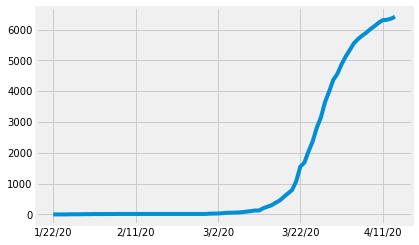

In [9]:
Aus = grouped.loc["Australia"] 
Aus.plot(kind='line')

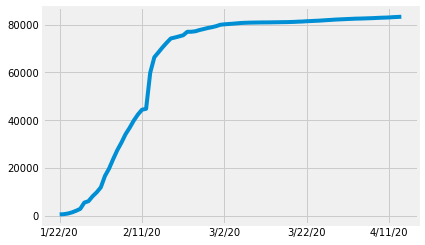

In [10]:
China = grouped.loc["China"] 
China.plot(kind='line')

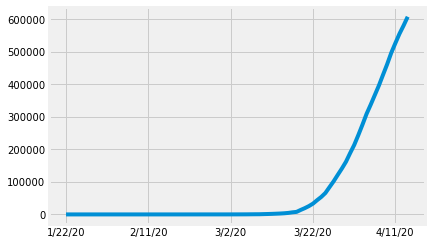

In [11]:
Us = grouped.loc["US"] 
Us.plot(kind='line')

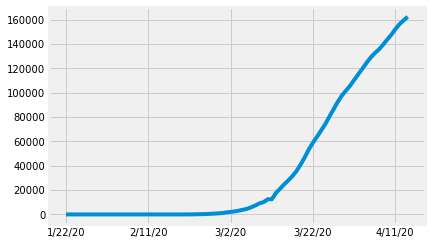

In [12]:
IT = grouped.loc["Italy"] 
IT.plot(kind='line')

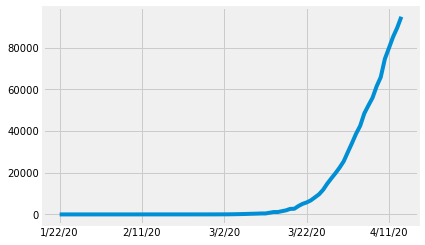

In [13]:
UK = grouped.loc["United Kingdom"] 
UK.plot(kind='line')

## Comparing Countries

One of the classic displays in the news is the comparison between countries.  Select a number of countries and plot their data on the same graph to reproduce this visualisation. Suitable countries would be those who have significant outbreaks - China, USA, Italy, UK, Australia. 

### The graph below shows all the countrie's confirmed cases

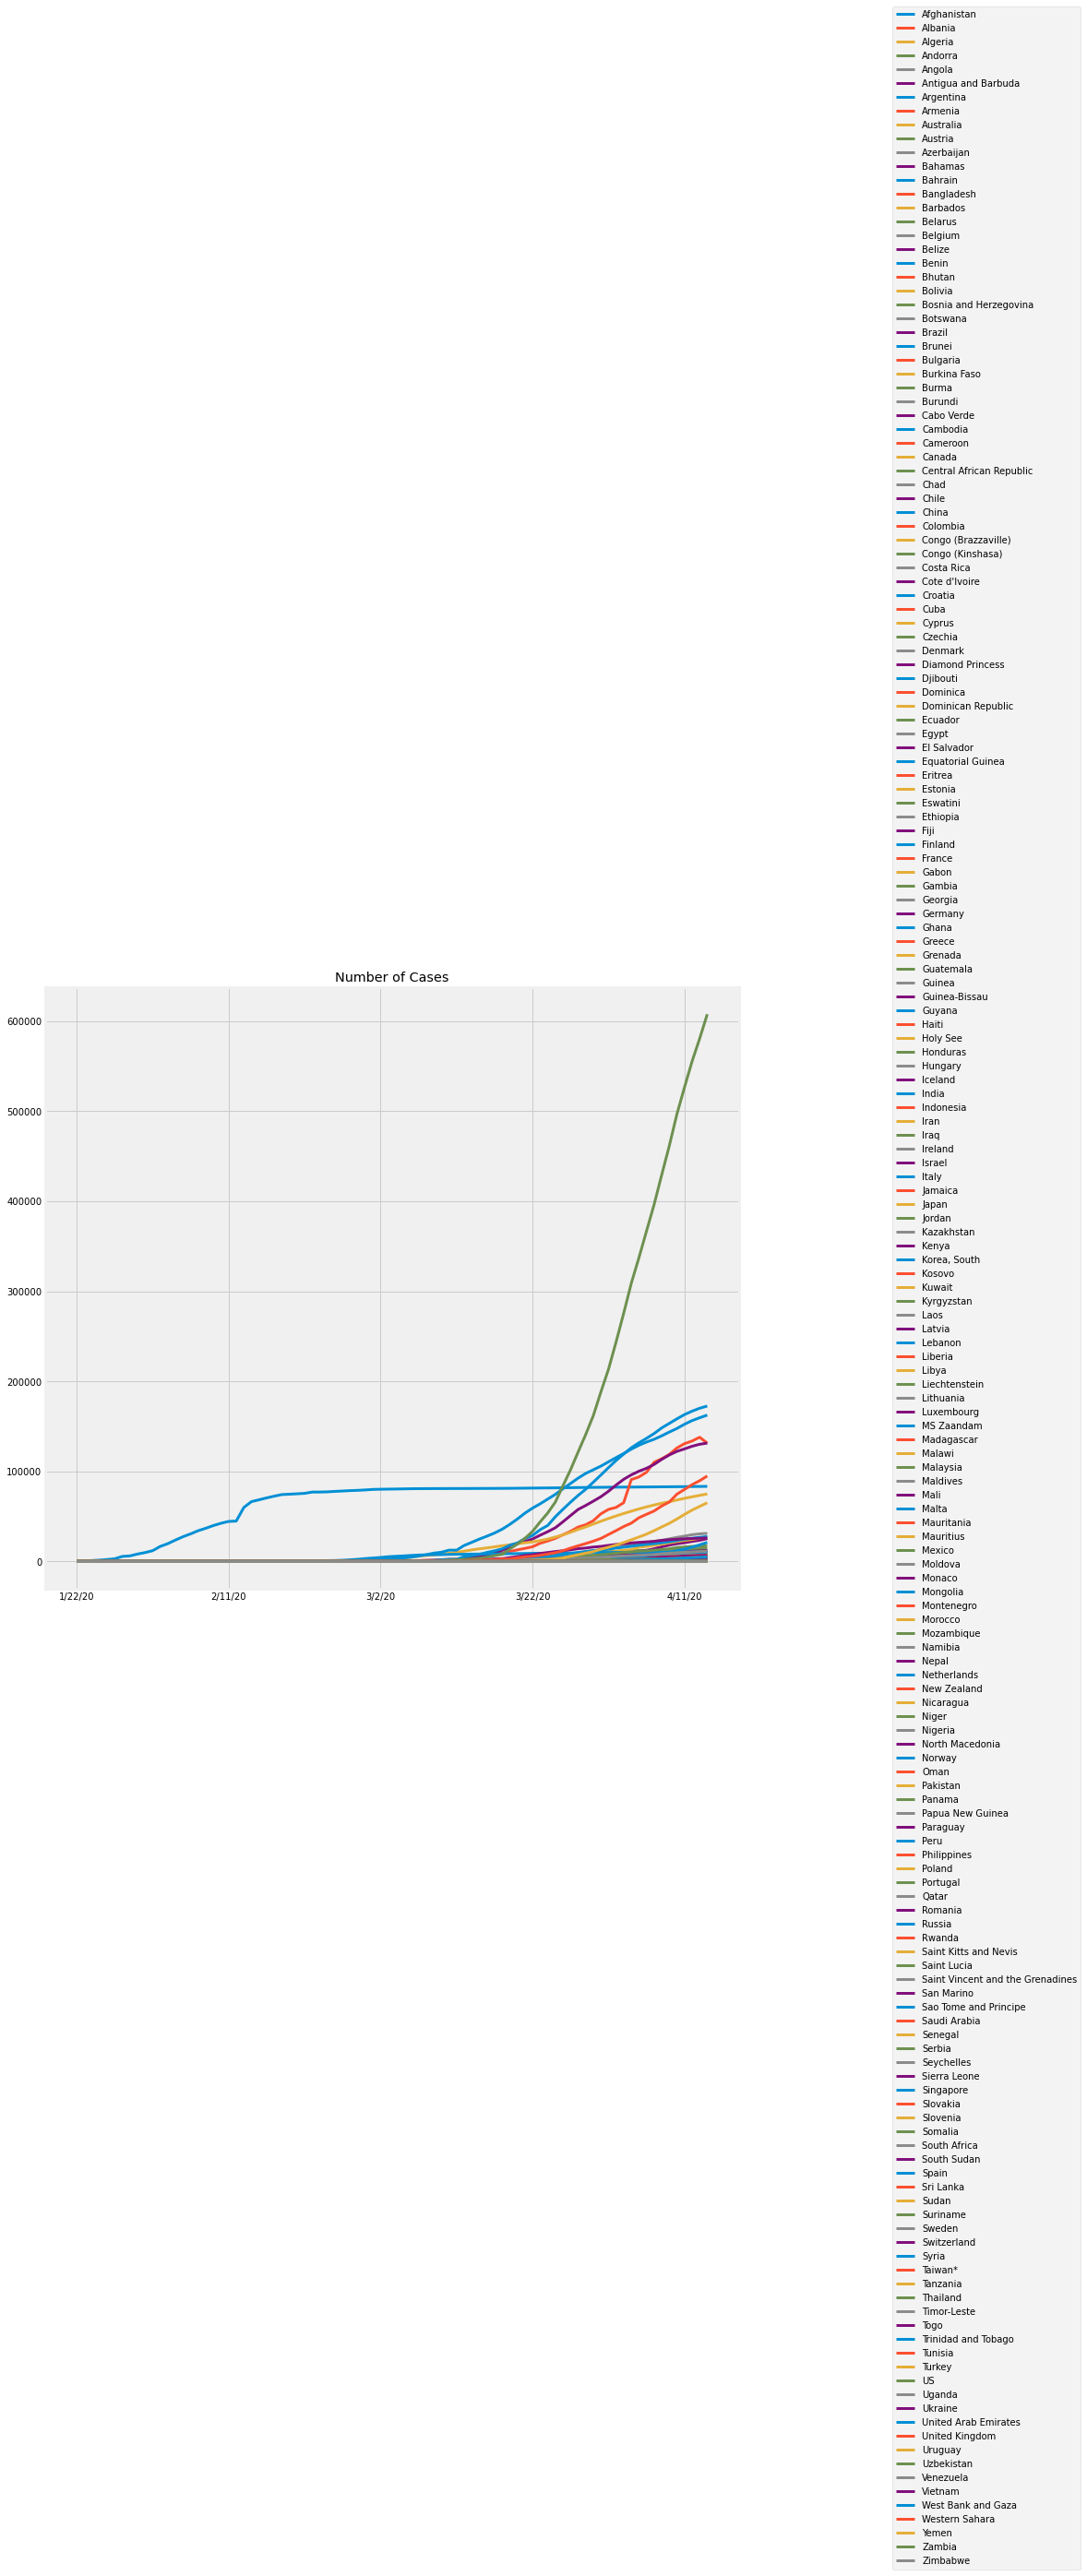

In [14]:
grouped.transpose().plot(figsize=(12,12), linewidth=3, title='Number of Cases')
plt.legend(loc='right', bbox_to_anchor=(1.5, 0.5))
plt.show()

## Analysing China, Usa, Italy, UK and Australia's confirmed, recovered and death cases.  

In [15]:
dates = confirmed.keys()
world_cases = []
total_deaths = []
mortality_rate = []
recovery_rate = []
total_recovered = []
total_active = []

australia_cases = []
china_cases = []
us_cases = []
italy_cases = []
uk_cases = []

australia_deaths = []
china_deaths = []
us_deaths = []
italy_deaths = []
uk_deaths = []

australia_recoveries = []
china_recoveries = [] 
us_recoveries = []
italy_recoveries = []
uk_recoveries = []

In [16]:
for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    
    # confirmed, deaths, recovered, and active
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    total_recovered.append(recovered_sum)
    total_active.append(confirmed_sum-death_sum-recovered_sum)
    
    # calculate rates
    mortality_rate.append(death_sum/confirmed_sum)
    recovery_rate.append(recovered_sum/confirmed_sum)

    # case studies 
    australia_cases.append(confirmed_df[confirmed_df['Country/Region']=='Australia'][i].sum())
    china_cases.append(confirmed_df[confirmed_df['Country/Region']=='China'][i].sum())
    us_cases.append(confirmed_df[confirmed_df['Country/Region']=='US'][i].sum())
    italy_cases.append(confirmed_df[confirmed_df['Country/Region']=='Italy'][i].sum())
    uk_cases.append(confirmed_df[confirmed_df['Country/Region']=='United Kingdom'][i].sum())
    
    australia_deaths.append(deaths_df[deaths_df['Country/Region']=='Australia'][i].sum())
    china_deaths.append(deaths_df[deaths_df['Country/Region']=='China'][i].sum())
    us_deaths.append(deaths_df[deaths_df['Country/Region']=='US'][i].sum())
    italy_deaths.append(deaths_df[deaths_df['Country/Region']=='Italy'][i].sum())
    uk_deaths.append(deaths_df[deaths_df['Country/Region']=='United Kingdom'][i].sum())
    
    australia_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='Australia'][i].sum())
    china_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='China'][i].sum())
    italy_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='Italy'][i].sum())
    us_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='US'][i].sum())
    uk_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='United Kingdom'][i].sum())

In [17]:
def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 

In [18]:
# confirmed cases
world_daily_increase = daily_increase(world_cases)
australia_daily_increase = daily_increase(australia_cases)
china_daily_increase = daily_increase(china_cases)
us_daily_increase = daily_increase(us_cases)
italy_daily_increase = daily_increase(italy_cases)
uk_daily_increase = daily_increase(uk_cases)

# deaths
world_daily_death = daily_increase(total_deaths)
australia_daily_death = daily_increase(australia_deaths)
china_daily_death = daily_increase(china_deaths)
us_daily_death = daily_increase(us_deaths)
italy_daily_death = daily_increase(italy_deaths)
uk_daily_death = daily_increase(uk_deaths)

# recoveries
world_daily_recovery = daily_increase(total_recovered)
australia_daily_recovery = daily_increase(australia_recoveries)
china_daily_recovery = daily_increase(china_recoveries)
us_daily_recovery = daily_increase(us_recoveries)
italy_daily_recovery = daily_increase(italy_recoveries)
uk_daily_recovery = daily_increase(uk_recoveries)

In [19]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)
total_recovered = np.array(total_recovered).reshape(-1, 1)

In [20]:
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]

In [21]:
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

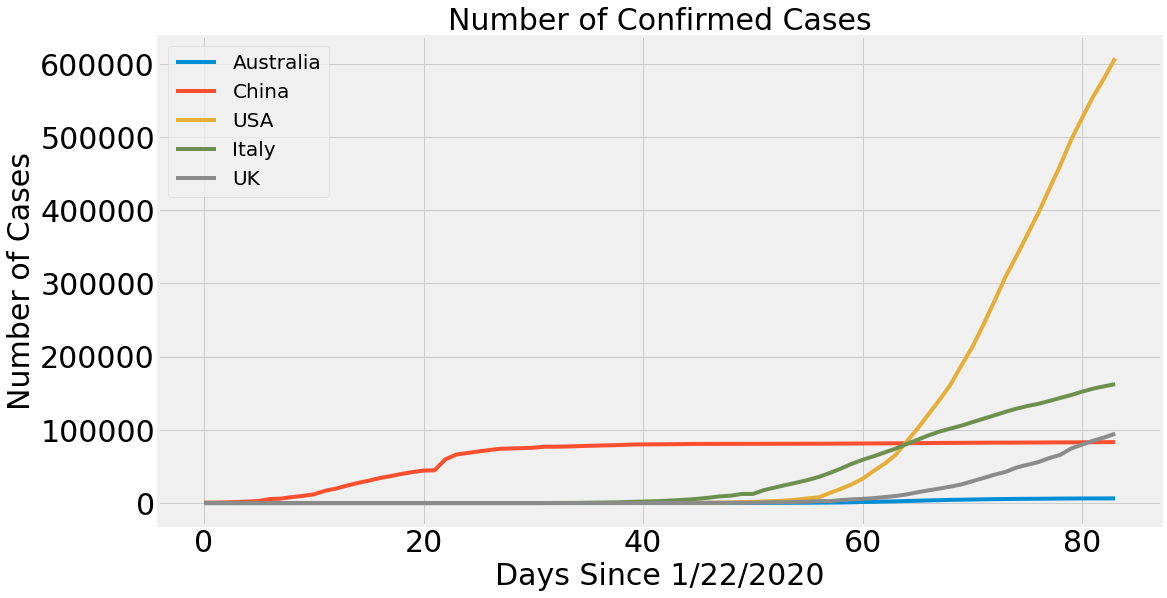

In [22]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, australia_cases)
plt.plot(adjusted_dates, china_cases)
plt.plot(adjusted_dates, us_cases)
plt.plot(adjusted_dates, italy_cases)
plt.plot(adjusted_dates, uk_cases)

plt.title('Number of Confirmed Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Number of Cases', size=30)
plt.legend(['Australia', 'China', 'USA', 'Italy', 'UK'], prop={'size': 20})
plt.xticks(size=30)
plt.yticks(size=30)
plt.show()

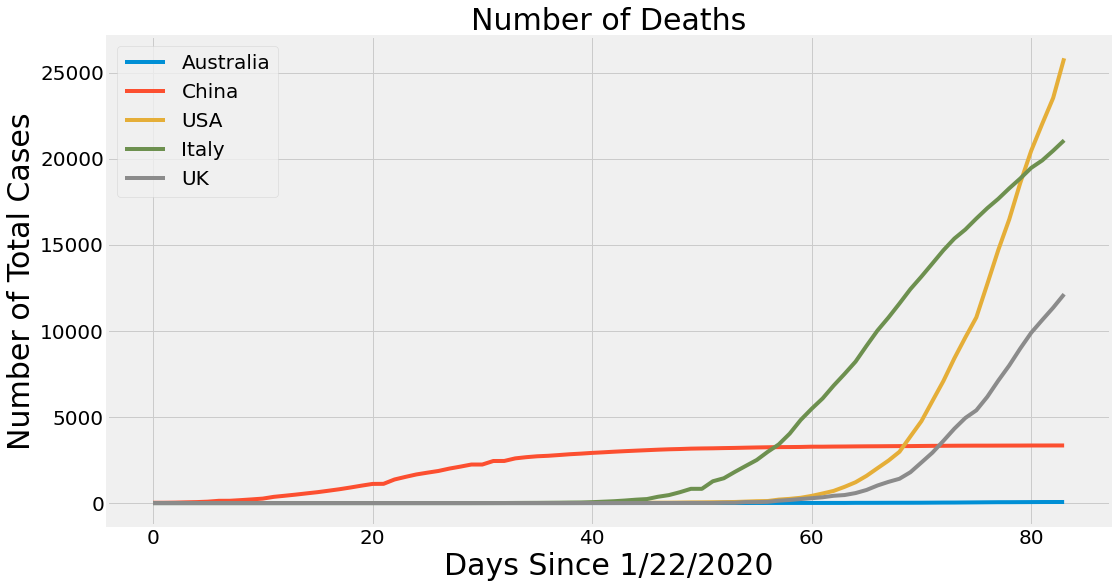

In [23]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, australia_deaths)
plt.plot(adjusted_dates, china_deaths)
plt.plot(adjusted_dates, us_deaths)
plt.plot(adjusted_dates, italy_deaths)
plt.plot(adjusted_dates, uk_deaths)
plt.title('Number of Deaths', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Number of Total Cases', size=30)
plt.legend(['Australia', 'China', 'USA', 'Italy', 'UK'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

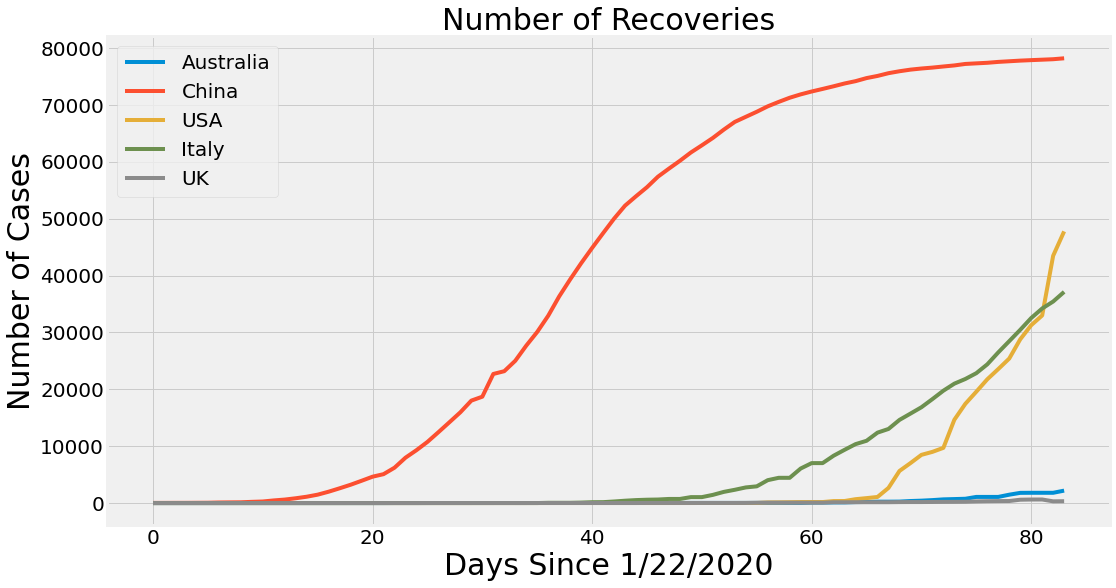

In [24]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, australia_recoveries)
plt.plot(adjusted_dates, china_recoveries)
plt.plot(adjusted_dates, us_recoveries)
plt.plot(adjusted_dates, italy_recoveries)
plt.plot(adjusted_dates, uk_recoveries)
plt.title('Number of Recoveries', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Number of Cases', size=30)
plt.legend(['Australia', 'China', 'USA', 'Italy', 'UK'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()